# GAN with Wasserstein Loss

Implementation of the paper :
* [Wasserstein GAN](https://arxiv.org/pdf/1701.07875.pdf)

In [1]:
from IPython.display import HTML
from celluloid import Camera
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.nn.utils import clip_grad_norm_
import copy

from models import Generator, Discriminator

## Explicit Transformation
Let $U \sim \text{Unif}(0,1)$. It has undergone a transformation $\mathscr{T}:U \rightarrow X $ to produce a new variable $X$ where, 
$$x = \mathscr{T}(u) = (u^2+1) + (2-u^2)$$.   
So for us the $p_{\text{data}}$ is the underlying distribution of X.

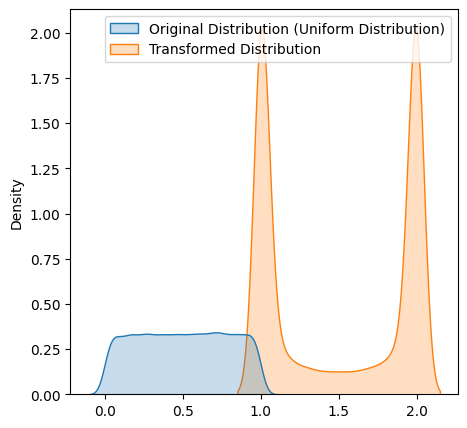

In [2]:
num_samples = 32000
u = np.array([np.random.rand() for i in range(num_samples)])
x = np.array([1+(i**10) for i in u]+[2-(i**10) for i in u])

dic = {'Original Distribution (Uniform Distribution)': u,
       'Transformed Distribution' : x}
plt.figure(figsize=(5,5))
sns.kdeplot(dic, fill = True)
plt.show()

In [3]:
latent_dim = 10
output_dim = 1
batch_size = 512

In [4]:
gen = Generator(latent_dim, output_dim)
disc = Discriminator(output_dim)

gen_opt = Adam(gen.parameters(), lr = 1e-4, betas=(0, 0.999))
disc_opt = Adam(disc.parameters(), lr = 1e-4, betas=(0, 0.999))

In [5]:
x = x.reshape(-1, batch_size, 1)
x.shape

(125, 512, 1)

## Notes

In [6]:
epochs = 5000
disc_steps = 10
lookaheads = 5

fig = plt.figure()
plt.xlim(-0.5,3)
plt.ylim(0,3)
camera = Camera(fig)
for epoch in range(epochs):
    gen.train()
    x = x.reshape(-1, 1)
    np.random.shuffle(x)
    x = x.reshape(-1, batch_size, 1)
    disc_score_list = []
    
    ## Discriminator ##
    for idx in range(disc_steps):
        batch_idx = np.random.randint(0,len(x))
        batch = torch.tensor(x[batch_idx], dtype=torch.float32)
        z = torch.randn(size = (batch_size, latent_dim), dtype=torch.float32)
        fake_pred = torch.mean(disc(gen(z)))
        real_pred = torch.mean(disc(batch))
        
        disc_score = (real_pred-fake_pred)
        disc_score_list.append(torch.mean(disc_score).item())
        disc_score.backward()
        # Cliping gradient is also very important for stable training
        clip_grad_norm_(disc.parameters(), 1)
        disc_opt.step()
        disc_opt.zero_grad()
        gen_opt.zero_grad()
        
    disc_score = np.mean(disc_score_list)
    
    ## Generator ##    
    z = torch.randn(size = (batch_size, latent_dim), dtype=torch.float32)
    gen_score = torch.mean(disc(gen(z)))
    clip_grad_norm_(gen.parameters(), 1)
    gen_score.backward()
    gen_opt.step()
    gen_opt.zero_grad()

    if (epoch+1)%10 == 0 or epoch == 0:
        gen.eval()
        z = torch.randn(size=(num_samples, latent_dim), requires_grad=False)
        x_gen = gen(z).detach().numpy().reshape(-1)
        map_final = {'Original Distribution': x.reshape(-1), 'Generator Distribution': x_gen}
        plot = sns.kdeplot(map_final, fill = True) 
        camera.snap()
    if (epoch+1) % 500 == 0:
        print(f"{epoch+1}/{epochs} Discriminator : {disc_score:.2f} \t Generator : {torch.mean(gen_score).item():.2f}")
plt.close()

500/5000 Discriminator : -2.89 	 Generator : -9.36
1000/5000 Discriminator : -15.90 	 Generator : -190.66
1500/5000 Discriminator : -19.88 	 Generator : -593.27
2000/5000 Discriminator : -37.21 	 Generator : -1687.52
2500/5000 Discriminator : -67.24 	 Generator : -4000.72
3000/5000 Discriminator : -87.46 	 Generator : -7815.36
3500/5000 Discriminator : -104.59 	 Generator : -13336.42
4000/5000 Discriminator : -127.05 	 Generator : -20850.20
4500/5000 Discriminator : -159.99 	 Generator : -31070.98
5000/5000 Discriminator : -165.74 	 Generator : -44628.70


<Axes: ylabel='Density'>

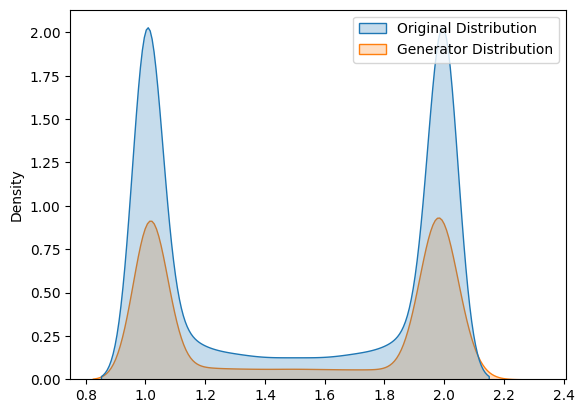

In [7]:
gen.eval()
z = torch.randn(size=(num_samples, latent_dim), requires_grad=False)
x_gen = gen(z).detach().numpy().reshape(-1)
map_final = {'Original Distribution': x.reshape(-1), 'Generator Distribution': x_gen}
sns.kdeplot(map_final, fill = True) 

In [8]:
animation = camera.animate(repeat=False)

In [9]:
animation.save('videos/Wasserstein-Bimodal.mp4', writer = 'ffmpeg', fps = 30)
HTML(animation.to_html5_video())